In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
# from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [2]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
K = X.shape[2]

In [10]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [13]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [15]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [16]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [17]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 30, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [19]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=15, callbacks=callbacks_list)

Epoch 1/15
13/13 [==============================] - 18s 482ms/step - loss: 2.8032 - accuracy: 0.1107

Epoch 00001: accuracy improved from -inf to 0.12004, saving model to best-model.hdf5
Epoch 2/15
13/13 [==============================] - 6s 470ms/step - loss: 2.5055 - accuracy: 0.1896

Epoch 00002: accuracy improved from 0.12004 to 0.19779, saving model to best-model.hdf5
Epoch 3/15
13/13 [==============================] - 6s 472ms/step - loss: 2.2981 - accuracy: 0.2586

Epoch 00003: accuracy improved from 0.19779 to 0.28302, saving model to best-model.hdf5
Epoch 4/15
13/13 [==============================] - 6s 472ms/step - loss: 1.8507 - accuracy: 0.3813

Epoch 00004: accuracy improved from 0.28302 to 0.40501, saving model to best-model.hdf5
Epoch 5/15
13/13 [==============================] - 6s 472ms/step - loss: 1.5352 - accuracy: 0.4783

Epoch 00005: accuracy improved from 0.40501 to 0.51952, saving model to best-model.hdf5
Epoch 6/15
13/13 [==============================] - 6s 47

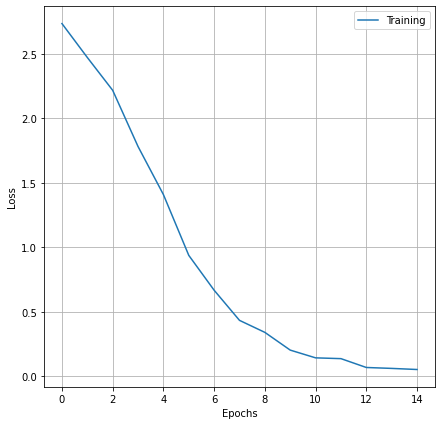

In [22]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

In [23]:
import pandas as pd
pd.DataFrame(history.history)

,loss,accuracy
0,2.732762,0.120039
1,2.470052,0.197788
2,2.215632,0.283019
3,1.780045,0.405010
4,1.407704,0.519519
5,0.936735,0.677619
6,0.666541,0.784971
7,0.433096,0.867274
8,0.339994,0.887118
9,0.202589,0.937541


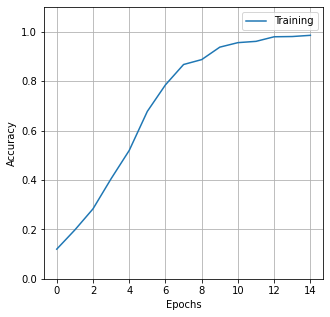

In [24]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [25]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [26]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [27]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [28]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
y_pred_test.shape

(7175,)

In [29]:
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       0.99      0.99      0.99      1000
           2       0.98      1.00      0.99       581
           3       0.99      0.99      0.99       166
           4       1.00      0.97      0.99       338
           5       1.00      0.99      0.99       511
           6       1.00      0.95      0.97        20
           7       1.00      1.00      1.00       335
           8       1.00      0.79      0.88        14
           9       0.99      0.99      0.99       680
          10       0.99      1.00      0.99      1719
          11       0.99      0.98      0.99       415
          12       1.00      0.98      0.99       143
          13       1.00      1.00      1.00       886
          14       0.99      1.00      0.99       270
          15       0.98      0.97      0.98        65

    accuracy                           0.99      7175
   macro avg       0.99   

In [30]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [31]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [32]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 6s 25ms/step - loss: 0.0323 - accuracy: 0.9914


In [33]:
print("Classification:")
print(classification)

Classification:
                              precision    recall  f1-score   support

                     Alfalfa       0.97      1.00      0.98        32
                 Corn-notill       0.99      0.99      0.99      1000
                Corn-mintill       0.98      1.00      0.99       581
                        Corn       0.99      0.99      0.99       166
               Grass-pasture       1.00      0.97      0.99       338
                 Grass-trees       1.00      0.99      0.99       511
         Grass-pasture-mowed       1.00      0.95      0.97        20
               Hay-windrowed       1.00      1.00      1.00       335
                        Oats       1.00      0.79      0.88        14
              Soybean-notill       0.99      0.99      0.99       680
             Soybean-mintill       0.99      1.00      0.99      1719
               Soybean-clean       0.99      0.98      0.99       415
                       Wheat       1.00      0.98      0.99       143
   

In [34]:
print("confusion matrix:")
print(confusion)

confusion matrix:
[[  32    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  987    0    0    0    0    0    0    0    3    9    0    0    0
     0    0]
 [   0    1  580    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  165    0    0    0    0    0    1    0    0    0    0
     0    0]
 [   0    0    0    0  329    0    0    0    0    4    1    0    0    0
     4    0]
 [   0    4    0    2    0  504    0    0    0    0    1    0    0    0
     0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    1    0    0
     0    0]
 [   0    0    0    0    0    0    0  335    0    0    0    0    0    0
     0    0]
 [   0    0    3    0    0    0    0    0   11    0    0    0    0    0
     0    0]
 [   0    3    0    0    0    0    0    0    0  673    4    0    0    0
     0    0]
 [   0    2    0    0    0    2    0    0    0    2 1713    0    0    0
     0    0]
 [   0    0    6    0    0    0    0    0    0 

In [35]:
print("Kappa accuracy (%)")
print(kappa)
print("Overall accuracy (%)")
print(oa)
print("Average accuracy (%)")
print(aa)
print("Test_accuracy")
print(Test_accuracy)

Kappa accuracy (%)
99.0304124077438
Overall accuracy (%)
99.14982578397212
Average accuracy (%)
97.4444641313652
Test_accuracy
99.14982318878174


In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [37]:
# load the original image
X, y = loadData(dataset)

In [38]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [39]:
X,pca = applyPCA(X, numComponents=numComponents)

In [40]:
X = padWithZeros(X, PATCH_SIZE//2)

In [41]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

c:\users\ujwal\appdata\local\programs\python\python38\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning:


The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

c:\users\ujwal\appdata\local\programs\python\python38\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



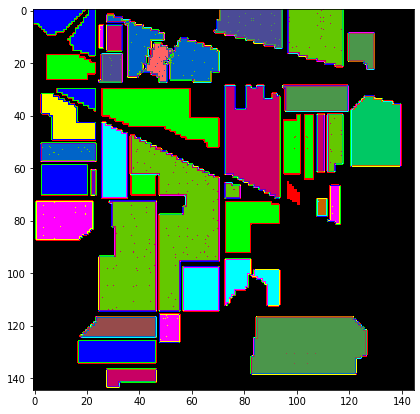

In [42]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

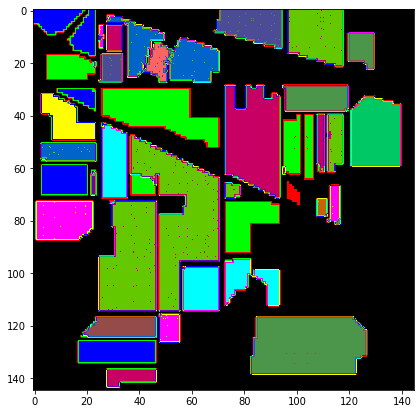

In [43]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [44]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)